# 기울기

In [10]:
import numpy as np

def numerical_gradient(f,x):
  h = 1e-4
  grad = np.zeros_like(x)

  for idx in range(x.size):
    tmp_val = x[idx]
    x[idx] = tmp_val + h
    fxh1 = f(x)

    # f(x-h) 계산
    x[idx] = tmp_val -h
    fxh2 =f(x)

    grad[idx] = (fxh1 - fxh2) / (2*h)
    x[idx] = tmp_val

  return grad

def function_2(x):
  return x[0] ** 2 + x[1] ** 2

In [11]:
print(numerical_gradient(function_2, np.array([3.0,4.0])))
print(numerical_gradient(function_2, np.array([0.0,2.0])))
print(numerical_gradient(function_2, np.array([3.0,0.0])))



[6. 8.]
[0. 4.]
[6. 0.]


In [13]:
def gradient_descent(f, init_x, lr = 0.01, step_num = 100):
  x = init_x

  for i in range(step_num):
    grad = numerical_gradient(f,x)
    x -= lr * grad
  return x

def function_2(x):
  return x[0] ** 2 + x[1] ** 2

init_x = np.array([-3.0,4.0])
gradient_descent(function_2, init_x = init_x, lr = 0.1, step_num = 100)

array([-6.11110793e-10,  8.14814391e-10])

신경망에서의 기울기

In [27]:
import numpy as np

def numerical_gradient(f, x):
    h = 1e-4  # 0.0001
    grad = np.zeros_like(x)

    it = np.nditer(x, flags=['multi_index'], op_flags=['readwrite'])
    while not it.finished:
        idx = it.multi_index
        tmp_val = x[idx]
        x[idx] = float(tmp_val) + h
        fxh1 = f(x)  # f(x+h)

        x[idx] = tmp_val - h
        fxh2 = f(x)  # f(x-h)
        grad[idx] = (fxh1 - fxh2) / (2*h)

        x[idx] = tmp_val  # 값 복원
        it.iternext()

    return grad

def softmax(x):
    if x.ndim == 2:
        x = x.T
        x = x - np.max(x, axis=0)
        y = np.exp(x) / np.sum(np.exp(x), axis=0)
        return y.T

    x = x - np.max(x) # 오버플로 대책
    return np.exp(x) / np.sum(np.exp(x))


def cross_entropy_error(y, t):
    if y.ndim == 1:
        t = t.reshape(1, t.size)
        y = y.reshape(1, y.size)

    # 훈련 데이터가 원-핫 벡터라면 정답 레이블의 인덱스로 반환
    if t.size == y.size:
        t = t.argmax(axis=1)

    batch_size = y.shape[0]
    return -np.sum(np.log(y[np.arange(batch_size), t])) / batch_size

# 4.4.2 신경망에서의 기울기
class simpleNet:
    """docstring for simpleNet"""
    def __init__(self):
        self.W = np.random.randn(2, 3)  # 정규분포로 초기화

    def predict(self, x):
        return np.dot(x, self.W)

    def loss(self, x, t):
        z = self.predict(x)
        y = softmax(z)
        loss = cross_entropy_error(y, t)

        return loss


net = simpleNet()
print(net.W)  # 가중치 매개변수(랜덤)
x = np.array([0.6, 0.9])
p = net.predict(x)
print(p)
print(np.argmax(p))  # 최댓값의 인덱스

t = np.array([0, 0, 1])  # 정답 레이블
print(net.loss(x, t))


def f(W):
    return net.loss(x, t)


dW = numerical_gradient(f, net.W)
print(dW)

[[-0.36033109  0.23218542 -0.14784709]
 [-0.73457731 -0.08945813 -2.25685866]]
[-0.87731823  0.05879894 -2.11988105]
1
2.587697690022777
[[ 0.15630274  0.39858148 -0.55488422]
 [ 0.23445411  0.59787222 -0.83232634]]


# **2층 신경망 클래스 구현하기**

**common **

In [28]:
# # coding: utf-8
# import numpy as np


# def identity_function(x):
#     return x


# def step_function(x):
#     return np.array(x > 0, dtype=np.int)


# def sigmoid(x):
#     return 1 / (1 + np.exp(-x))


# def sigmoid_grad(x):
#     return (1.0 - sigmoid(x)) * sigmoid(x)


# def relu(x):
#     return np.maximum(0, x)


# def relu_grad(x):
#     grad = np.zeros(x)
#     grad[x>=0] = 1
#     return grad


# def softmax(x):
#     if x.ndim == 2:
#         x = x.T
#         x = x - np.max(x, axis=0)
#         y = np.exp(x) / np.sum(np.exp(x), axis=0)
#         return y.T

#     x = x - np.max(x) # 오버플로 대책
#     return np.exp(x) / np.sum(np.exp(x))


# def mean_squared_error(y, t):
#     return 0.5 * np.sum((y-t)**2)


# def cross_entropy_error(y, t):
#     if y.ndim == 1:
#         t = t.reshape(1, t.size)
#         y = y.reshape(1, y.size)

#     # 훈련 데이터가 원-핫 벡터라면 정답 레이블의 인덱스로 반환
#     if t.size == y.size:
#         t = t.argmax(axis=1)

#     batch_size = y.shape[0]
#     return -np.sum(np.log(y[np.arange(batch_size), t])) / batch_size


# def softmax_loss(X, t):
#     y = softmax(X)
#     return cross_entropy_error(y, t)


In [29]:
# # coding: utf-8
# import numpy as np

# def _numerical_gradient_1d(f, x):
#     h = 1e-4 # 0.0001
#     grad = np.zeros_like(x)

#     for idx in range(x.size):
#         tmp_val = x[idx]
#         x[idx] = float(tmp_val) + h
#         fxh1 = f(x) # f(x+h)

#         x[idx] = tmp_val - h
#         fxh2 = f(x) # f(x-h)
#         grad[idx] = (fxh1 - fxh2) / (2*h)

#         x[idx] = tmp_val # 값 복원

#     return grad

In [31]:
# import numpy as np

# class TwoLayerNet:

#     def __init__(self, input_size, hidden_size, output_size, weight_init_std=0.01):
#         # 가중치 초기화
#         self.params = {}
#         self.params['W1'] = weight_init_std * np.random.randn(input_size, hidden_size)
#         self.params['b1'] = np.zeros(hidden_size)
#         self.params['W2'] = weight_init_std * np.random.randn(hidden_size, output_size)
#         self.params['b2'] = np.zeros(output_size)

#     def predict(self, x):
#         W1, W2 = self.params['W1'], self.params['W2']
#         b1, b2 = self.params['b1'], self.params['b2']

#         a1 = np.dot(x, W1) + b1
#         z1 = sigmoid(a1)
#         a2 = np.dot(z1, W2) + b2
#         y = softmax(a2)

#         return y

#     # x : 입력 데이터, t : 정답 레이블
#     def loss(self, x, t):
#         y = self.predict(x)

#         return cross_entropy_error(y, t)

#     def accuracy(self, x, t):
#         y = self.predict(x)
#         y = np.argmax(y, axis=1)
#         t = np.argmax(t, axis=1)

#         accuracy = np.sum(y == t) / float(x.shape[0])
#         return accuracy

#     # x : 입력 데이터, t : 정답 레이블
#     def numerical_gradient(self, x, t):
#         loss_W = lambda W: self.loss(x, t)

#         grads = {}
#         grads['W1'] = numerical_gradient(loss_W, self.params['W1'])
#         grads['b1'] = numerical_gradient(loss_W, self.params['b1'])
#         grads['W2'] = numerical_gradient(loss_W, self.params['W2'])
#         grads['b2'] = numerical_gradient(loss_W, self.params['b2'])

#         return grads

#     def gradient(self, x, t):
#         W1, W2 = self.params['W1'], self.params['W2']
#         b1, b2 = self.params['b1'], self.params['b2']
#         grads = {}

#         batch_num = x.shape[0]

#         # forward
#         a1 = np.dot(x, W1) + b1
#         z1 = sigmoid(a1)
#         a2 = np.dot(z1, W2) + b2
#         y = softmax(a2)

#         # backward
#         dy = (y - t) / batch_num  # ????
#         grads['W2'] = np.dot(z1.T, dy)
#         grads['b2'] = np.sum(dy, axis=0)

#         da1 = np.dot(dy, W2.T)
#         dz1 = sigmoid_grad(a1) * da1
#         grads['W1'] = np.dot(x.T, dz1)
#         grads['b1'] = np.sum(dz1, axis=0)

#         return grads

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 512)               401920    
                                                                 
 dense_3 (Dense)             (None, 10)                5130      
                                                                 
Total params: 407,050
Trainable params: 407,050
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
938/938 [==============================] - 11s 11ms/step - loss: 0.2248 - accuracy: 0.9344
Epoch 2/10
938/938 [==============================] - 8s 9ms/step - loss: 0.0901 - accuracy: 0.9724
Epoch 3/10
938/938 [==============================] - 9s 9ms/step - loss: 0.0592 - accuracy: 0.9821
Epoch 4/10
938/938 [==============================] - 9s 9ms/step - loss: 0.0435 - accuracy: 0.9867
Epoch 5/10
938/938 [======================

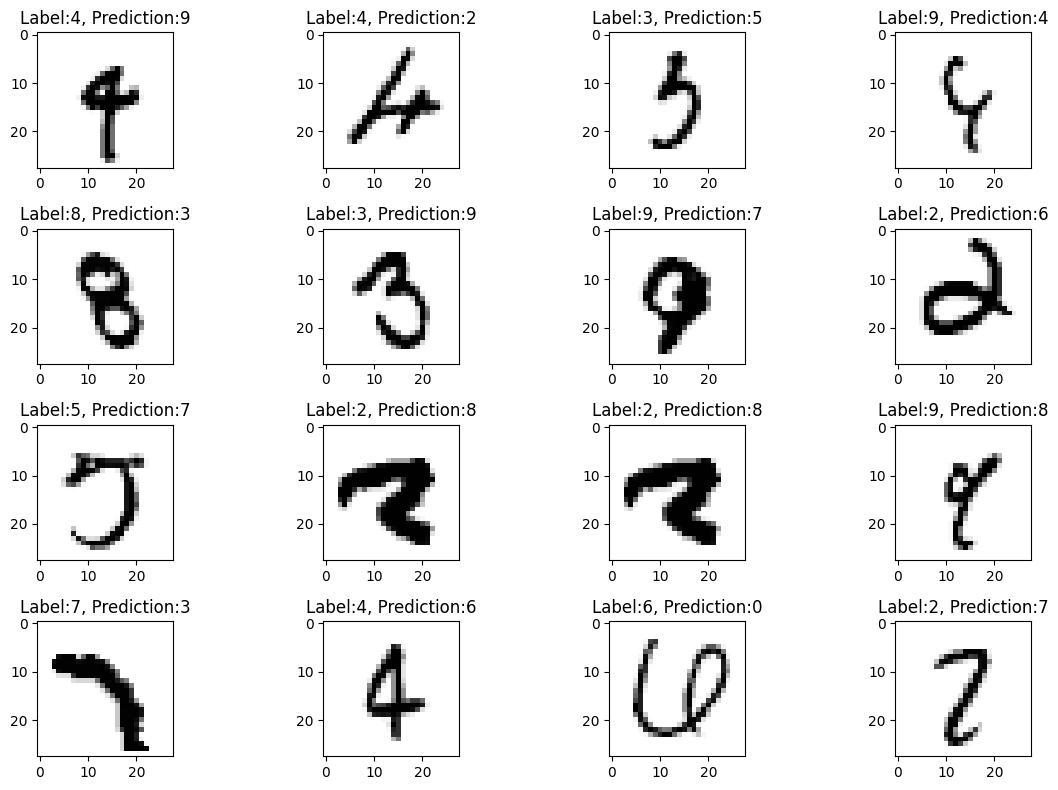

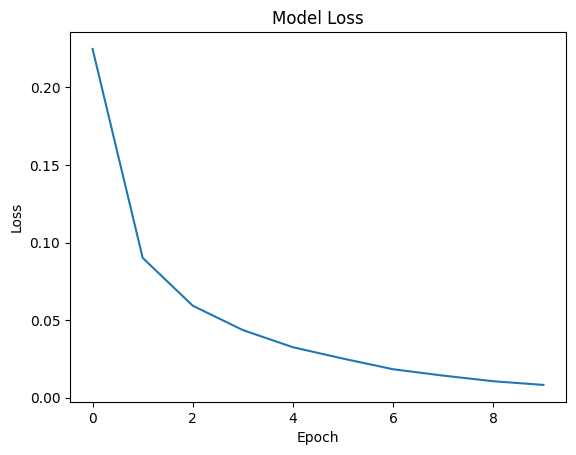

In [42]:
# 필요한 라이브러리 불러오기
from keras.datasets import mnist
from keras import models
from keras import layers
from keras.utils import to_categorical
import matplotlib.pyplot as plt
from keras.utils import plot_model

# MNIST 데이터셋 불러오기
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

# 이미지 데이터 준비하기 (모델에 맞는 크기로 바꾸고 0과 1사이로 스케일링)
train_images = train_images.reshape((60000, 28 * 28))
train_images = train_images.astype('float32') / 255
test_images = test_images.reshape((10000, 28 * 28))
test_images = test_images.astype('float32') / 255

# 레이블을 범주형으로 인코딩
train_labels = to_categorical(train_labels)
test_labels = to_categorical(test_labels)

# 모델 정의하기 (여기에서는 Sequential 클래스 사용)
model = models.Sequential()
model.add(layers.Dense(512, activation='relu', input_shape=(28 * 28,)))
model.add(layers.Dense(10, activation='softmax'))
model.summary()

# 구 조확인
from IPython.display import SVG
from keras.utils import model_to_dot

# SVG(model_to_dot(model, show_shapes=True).create(prog='dot',format='svg'))

# 모델 컴파일 하기
model.compile(optimizer='rmsprop',
                loss='categorical_crossentropy',
                metrics=['accuracy'])

# fit() 메서드로 모델 훈련 시키기
history=model.fit(train_images, train_labels,epochs=10, batch_size=64, verbose=1)
# batch size가 높을수록, 속도빠르고, 정화도가 낮아.

# 테스트 데이터로 정확도 측정하기
test_loss, test_acc = model.evaluate(test_images, test_labels, verbose=0)

print('Test loss:', test_loss)
print('Test accuracy:', test_acc)
# 학습 정확성 값과 검증 정확성 값을 플롯팅 합니다.

#결과파악.

import random
import numpy as np
predicted_result = model.predict(test_images)
predicted_labels = np.argmax(predicted_result, axis=1)

test_label = np.argmax(test_labels, axis=1)

wrong_result = []

for n in range(0, len(test_label)):
    if predicted_labels[n] != test_label[n]:
        wrong_result.append(n)

samples = random.choices(population=wrong_result, k=16)

count = 0
nrows = ncols = 4

plt.figure(figsize=(12,8))

for n in samples:
    count += 1
    plt.subplot(nrows, ncols, count)
    plt.imshow(test_images[n].reshape(28, 28), cmap='Greys', interpolation='nearest')
    tmp = "Label:" + str(test_label[n]) + ", Prediction:" + str(predicted_labels[n])
    plt.title(tmp)

plt.tight_layout()
plt.show()


plt.plot(history.history['loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

# **오차역전파법**

순전파, 역전파

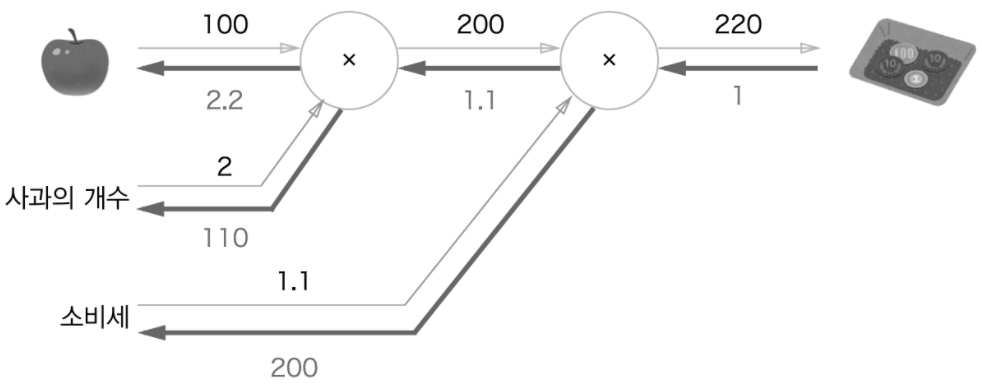

계층 구현하기

In [53]:
class MulLayer:
  def __init__(self):
    self.x = None
    self.y = None

  def forward(self, x, y):
    self.x = x
    self.y = y
    out = x * y
    return out

  def backward(self, dout):
    dx = dout * self.y
    dy = dout * self.x
    return dx, dy

In [61]:
apple = 100
apple_num = 2
tax = 1.1

#계층들

mul_apple_layer = MulLayer()
mul_tax_layer = MulLayer()

#순전파

apple_price = mul_apple_layer.forward(apple, apple_num)
price = mul_tax_layer.forward(apple_price, tax)
print("\n순전파")
print(int(price))

#역전파

dprice = 1
dapple_price, dtax = mul_tax_layer.backward(dprice)
dapple, dapple_num = mul_apple_layer.backward(dapple_price)

print("\n역전파")
print(dapple, dapple_num, dtax)


순전파
220

역전파
2.2 110.00000000000001 200


5.5 활설화 함수 계층 구현하기

In [66]:
class Relu:
  def __init__(self):
    self.mask = None

  def forward(self, x):
    self.mask = (x <= 0)
    out = x.copy()
    out[self.mask] = 0

    return out

  def backward(self, dout):
    dout[self.mask] = 0
    dx = dout

    return dx

x = np.array([[1.0, -0.5],[-2.0,3.0]])
print(x)

mask = (x <= 0)

print(mask)

[[ 1.  -0.5]
 [-2.   3. ]]
[[False  True]
 [ True False]]
